In [27]:
import gym
from envs.discrete_bs import BSEnv, decode_action, encode_action, encode_wealth, transform_Q_interval_to_Q_numeric, transform_Q_numeric_to_Q_interval, state_to_numeric
from envs import plotting

import numpy as np
import pandas as pd
import math
from collections import defaultdict
import itertools
import time
import matplotlib.pyplot as plt
from scipy import optimize

import dill
import pickle

**Action space**  
Actions denote the fraction of wealth invested in the **risky asset**. Actions are discretized with a step size of 10%, i.e.

$$
\mathcal{A}=[0, 0.1, 0.2, \dots, 0.9, 1].
$$

In [2]:
# Define the vector of actions, discrete investment decisions in 10% steps
actions = np.arange(0, 1.01, step=0.1)                  
print("Actions (Investment in risky asset):", actions)  

Actions (Investment in risky asset): [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


**Wealth discretisation**

In [3]:
lower = 60      # upper limit of the lowest bucket (0, 90]
upper = 160     # lower limit of the highest bucket (upper, +inf)
delta_bin = 5  # bin-size inbetween 
wealth_bins = np.array([0] + np.arange(lower, upper+1, delta_bin).tolist() + [float('Inf')])  # +1 as upper limit is not included
#wealth_bins = np.arange(lower, upper+1, delta_bin)

print(pd.cut(x=[10], bins=wealth_bins, right=False, retbins=True)[0].categories)

IntervalIndex([[0.0, 60.0), [60.0, 65.0), [65.0, 70.0), [70.0, 75.0), [75.0, 80.0) ... [140.0, 145.0), [145.0, 150.0), [150.0, 155.0), [155.0, 160.0), [160.0, inf)],
              closed='left',
              dtype='interval[float64]')


**Discrete-time and discrete wealth Black-Scholes environment**

In [4]:
# Model parameters
'''
:params mu (float):         expected risky asset return
:params sigma (float):      risky asset standard deviation
:params r (float):          risk-less rate of return
:params T (float):          investment horizon
:params dt (float):         time-step size
:params V_0 (float, tuple): initial wealth, if tuple (v_d, v_u) draws initial wealth V(0) uniformly from [v_d, v_u]
:params actions (np.array): possible investment fractions into risky asset
:params wealth_bins (np.array): contains the limits of each wealth bin in ascending order
:params U_2 (callable):     utility function for terminal wealth (default log-utility)
'''

mu=0.06
sigma=0.2
r=0.04
T=2
dt=1
V_0=100
batch_size=1

env = BSEnv(mu=mu, sigma=sigma, r=r, T=T, dt=dt, V_0=V_0, actions=actions, wealth_bins=wealth_bins, batch_size=batch_size)

In [5]:
# Simulation of the wealth evolution in the BS market
done = False
print('Observation: {}, Exact_wealth: {}'.format(env.reset(), env.V_t))      # Reset the environment to state (0, 100)

while not done:
    print('Action: \n', decode_action(10, actions))
    next_obs, reward, done, info = env.step(10)              # Take the action 10 (i.e. 100% investment in risky asset) and observe the next state and reward
    print('Observation: {}, Reward: {}, Done: {}, Exact_wealth: {}'.format(next_obs, reward, done, env.V_t)),      

Observation: [[0 Interval(100.0, 105.0, closed='left')]], Exact_wealth: [100.]
Action: 
 1.0
Observation: [[1 Interval(150.0, 155.0, closed='left')]], Reward: [0.], Done: False, Exact_wealth: 151.92182647282402
Action: 
 1.0
Observation: [[2 Interval(155.0, 160.0, closed='left')]], Reward: [5.06650458], Done: True, Exact_wealth: 158.61891788145795


**Epsilon-Greedy Policy**\
Source: https://www.geeksforgeeks.org/q-learning-in-python/#:~:text=Q%2DLearning%20is%20a%20basic,defined%20for%20states%20and%20actions.

In [6]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions): 
    """ 
    Creates an epsilon-greedy policy based 
    on a given Q-function and epsilon. 
       
    Returns a function that takes the state 
    as an input and returns the probabilities 
    for each action in the form of a numpy array  
    of length of the action space(set of possible actions). 
    """
    def policyFunction(state): 
   
        Action_probabilities = np.ones(num_actions, 
                dtype = float) * epsilon / num_actions 
                  
        best_action = np.argmax(Q[state]) 
        Action_probabilities[best_action] += (1.0 - epsilon) 
        return Action_probabilities 
   
    return policyFunction

In [7]:
# Action-value function parametrisation in a BS market with log-utility function an no consumption.
def action_func(x, a, b, c):
    return a * (x**2) + b * x + c


def update_action_direction(Q, state, action, actions, func, learning_rate, p0):
    '''
    Updates all action-values across action direction by fitting the parametrised function to the empirical 
    action-values and taking a step of size learning rate towards the fitted values.
    
    Args:
    :params Q [dict]: A dictionary containing the action-values
    :params state [Tuple]: The state to be updated.
    :params action [int]: The current action to be updated. It is not touched when calulating the concave update
    :params actions [np.array]: The possible investment choices.
    :params func [callable]: The parametrised functional form of the action-value function in direction of inv. in risky asset
    :params learning_rate [Float]: The step_size parameter.
    :params p0 [List(float)]: Initial parameters of func as starting point for the optimisation.
    
    Returns:
        - np.array with length equal to len(actions): Updated action-values for the current state for each action.
        - params [List(Float)]: List of function parameters.
    '''
    
    # Function values to fit to
    y = Q[state]
    # Optimize parameters a,b,c to fit to the function values f
    params, _ = optimize.curve_fit(func, actions, y, p0=p0)
    
    # predicted values for all actions
    y_fitted = func(actions, params[0], params[1], params[2])
    # difference between predicted values and actual values
    y_diff = y_fitted - y
    y_diff[action] = 0   # does not update the current action
    
    # Update step according to learning rate
    return y + learning_rate*y_diff, params

**Q-Learning Algorithm**  
The general Q-Learning Algorithm Outline can be found under the link below.  
Source: https://www.geeksforgeeks.org/q-learning-in-python/#:~:text=Q%2DLearning%20is%20a%20basic,defined%20for%20states%20and%20actions.

In [8]:
def qLearning(env, num_episodes, actions, conc_func, conc_learning_rate, concavisation_start, discount_factor = 1, alpha = 1, epsilon = 1): 
    """ 
    Q-Learning algorithm: Off-policy TD control. 
    Finds the optimal greedy policy while improving 
    following an epsilon-greedy policy
    
    Args:
    :params env [gym.environment]: The environement used in the algorithm to sample trajectories.
    :params num_episodes [Int]: Number of training episodes.
    :params actions [np.array]: Numpy array containing the allocation possibilities to the risky asset.
    :params conc_func [Callable]: Function parametrisation used for the update steps in action direction every iteration.
    :params conc_learning_rate [Float]: The step_size used for a step towards the fitted action-values in the update state in action direction.
    :params concavisation_start [Int]: Number of episode, when to start with the updates in action direction as well.
    :params discount_factor [Float]: The discount factor.
    :params alpha [Float]: The learning rate for Q-Learning (not used for now, as updates are 1/num_state_action_visits)
    :params epsilon [Float]: Random exploration factor in Q-Learning.
    """
       
    # Action value function 
    # A nested dictionary that maps 
    # state -> (action -> action-value). 
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    A = defaultdict(lambda: np.zeros(env.action_space.n))     # Dictionary: Counts visits of state-actions pairs
    P = defaultdict(lambda: [-1, 1, 1])                       # Dictionary: Contains parameters of conc_func for concavisation 
                                                              #             used as initial parameters for the next optimisation
   
    # Keeps track of useful statistics 
    stats = plotting.EpisodeStats( 
        episode_lengths = np.zeros(num_episodes), 
        episode_rewards = np.zeros(num_episodes))     
       
        
    # Create an epsilon greedy policy function 
    # appropriately for environment action space 
    policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n) 
       
        
    # For every episode
    returns=np.array([])
    terminal_wealths = np.array([])
    
    
    for ith_episode in range(num_episodes): 
           
            
        # Reset the environment and pick the first action 
        state = state_to_numeric(env.reset()[0])
        
        
        for t in itertools.count(): 
               
            # get probabilities of all actions from current state 
            action_probabilities = policy(state)
            # choose action according to  
            # the probability distribution 
            action = np.random.choice(np.arange( 
                      len(action_probabilities)), 
                       p = action_probabilities)
            A[state][action] += 1
   
            # take action and get reward, transit to next state 
            # next_states: np.array of length batch_size
            # rewards:     np.array of length batch_size
            # done: True/False
            next_states, rewards, done, _ = env.step(action)
            # next_states: np.array of length batch size, each entry is a tuple (t, mean.v)
            next_states = np.array([state_to_numeric(next_state) for next_state in next_states])
            # mean_reward: float
            mean_reward = np.mean(rewards)
            
   
            # Update statistics 
            stats.episode_rewards[ith_episode] += mean_reward 
            stats.episode_lengths[ith_episode] = t
               
            
            # TD Update 
            # Selects the batch_size next best actions for each next state in next_states
            best_next_actions = np.array([np.argmax(Q[(next_state[0], next_state[1])]) for next_state in next_states])
            # Calculates the Q-values for each of the following states
            next_q_values = np.array([Q[(next_state[0], next_state[1])][best_next_action] for next_state, best_next_action in zip(next_states, best_next_actions)])
            # Calculate the td-target as the mean reward + \beta * mean_next_q_values 
            # (the higher the batch_size the less noise in the target!!!)
            td_target = mean_reward + discount_factor * np.mean(next_q_values)
            # Calculate the delta
            td_delta = td_target - Q[state][action]


            # Update the action-value for the current state
            Q[state][action] += (1/A[state][action]) * td_delta          # Dynamic Learning Rate alpha=1/#visits of state-action pair
                                                                         # ensures convergence see Sutton & Barto eq. (2.7)

                
            
            # Monotone updates
            
            if td_delta > 0:
                states_to_be_updated = [s_tilde for s_tilde in Q.keys() if (s_tilde[0] == state[0]) & (s_tilde[1] > state[1]) & (Q[s_tilde][action] < Q[state][action])]
                # get first state s_hat=(t, V_hat) with V_hat > V^* and Q(s_hat, action) >= Q[state, action]
                s_hat_list = sorted([s for s in Q.keys() if (s[0] == state[0]) & (s[1] > state[1]) & (Q[s][action] >= Q[state][action])], key=lambda x: x[1])
                
                
                # Update states in between via linear interpolation
                if len(s_hat_list) != 0:
                    s_hat = s_hat_list[0]
                    for s_tilde in states_to_be_updated:
                        Q[s_tilde][action] = Q[state][action] + (s_tilde[1] - state[1])*((Q[s_hat][action] - Q[state][action])/(s_hat[1] - state[1]))
               
                
                # No s_hat, hence update all s_tilde equally Q(s_tilde, action) = Q(s^*, action)
                else:
                    states_to_be_updated = [s_tilde for s_tilde in Q.keys() if (s_tilde[0] == state[0]) & (s_tilde[1] > state[1])]
                    for s_tilde in states_to_be_updated:
                        Q[s_tilde][action] = Q[state][action]
            
            
            elif td_delta < 0:
                states_to_be_updated = [s_tilde for s_tilde in Q.keys() if (s_tilde[0] == state[0]) & (s_tilde[1] < state[1]) & (Q[s_tilde][action] > Q[state][action])]
                # get first state s_hat=(t, V_hat) with V_hat < V^* and Q(s_hat, action) <= Q[state, action]
                s_hat_list = sorted([s for s in Q.keys() if (s[0] == state[0]) & (s[1] < state[1]) & (Q[s][action] <= Q[state][action])], key=lambda x: x[1], reverse=True)
                
                
                # Update states in between via linear interpolation
                if len(s_hat_list) != 0:
                    s_hat = s_hat_list[0]
                    for s_tilde in states_to_be_updated:
                        Q[s_tilde][action] = Q[s_hat][action] + (s_tilde[1] - s_hat[1])*((Q[state][action] - Q[s_hat][action])/(state[1] - s_hat[1]))
                
                
                # No s_hat, hence update all s_tilde equally Q(s_tilde, action) = Q(s^*, action)
                else:
                    states_to_be_updated = [s_tilde for s_tilde in Q.keys() if (s_tilde[0] == state[0]) & (s_tilde[1] < state[1])]
                    for s_tilde in states_to_be_updated:
                        Q[s_tilde][action] = Q[state][action]
                        
            else:
                pass
            
            
            # Updates in action direction (by parametrised function conc_func)
            # Starts after concavisation_start nr. of episodes
            #if ith_episode >= concavisation_start:
            #    # Updates all action-values for the current state (across risky asset allocation)
            #    new_action_values, params = update_action_direction(Q, state, action, actions, func=conc_func, learning_rate=conc_learning_rate, p0=P[state])
                # Update the Q-Table
            #    Q[state] = new_action_values
            #    # Save parameters of fitted function for the current state as starting point for the next optimisation
            #    P[state] = params
            
            
            
            # done is True if episode terminated    
            if done: 
                returns = np.append(returns, mean_reward)
                terminal_wealths=np.append(terminal_wealths, env.V_t)
                break
                   
            # Continue with the first next_state (simplifies, no need to average over wealths)        
            state = (next_states[0][0], next_states[0][1])
        
        if ith_episode % 10000 == 0:
            print("Episode: {}, Mean Return: {}, Mean Wealth (V_T): {}, Epsilon: {}".format(ith_episode, round(returns.mean(), 3), round(terminal_wealths.mean(), 3), epsilon))
            #print("td_delta:", td_delta)
            returns = np.array([])
            terminal_wealths=np.array([])
            
        # Epsilon-Decay    
        #if (ith_episode % 10000 == 0) & (ith_episode != 0):
        #    epsilon *= 0.98
        #    policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n)
        #    alpha = 0.1
        
        # Alpha-Decay
        #if (ith_episode % 30000 == 0) & (ith_episode != 0):
        #    if alpha > 0.0011:
        #        alpha *= 1/10
            
       
    return Q, stats, A

In [9]:
# Training of the Agent
num_episodes = 10000000   # Training for 10 mio. Episodes

# Starts timer
t_0 = time.time()

# Starts training
Q, stats, A = qLearning(env, num_episodes, actions, conc_func=action_func, conc_learning_rate = 1e-2, concavisation_start=10000)

# Ends timer
t_1 = time.time()

Episode: 0, Mean Return: 4.723, Mean Wealth (V_T): 112.482, Epsilon: 1
Episode: 10000, Mean Return: 4.69, Mean Wealth (V_T): 110.454, Epsilon: 1
Episode: 20000, Mean Return: 4.689, Mean Wealth (V_T): 110.289, Epsilon: 1
Episode: 30000, Mean Return: 4.689, Mean Wealth (V_T): 110.228, Epsilon: 1
Episode: 40000, Mean Return: 4.691, Mean Wealth (V_T): 110.46, Epsilon: 1
Episode: 50000, Mean Return: 4.692, Mean Wealth (V_T): 110.635, Epsilon: 1
Episode: 60000, Mean Return: 4.691, Mean Wealth (V_T): 110.501, Epsilon: 1
Episode: 70000, Mean Return: 4.692, Mean Wealth (V_T): 110.639, Epsilon: 1
Episode: 80000, Mean Return: 4.691, Mean Wealth (V_T): 110.579, Epsilon: 1
Episode: 90000, Mean Return: 4.69, Mean Wealth (V_T): 110.351, Epsilon: 1
Episode: 100000, Mean Return: 4.691, Mean Wealth (V_T): 110.451, Epsilon: 1
Episode: 110000, Mean Return: 4.691, Mean Wealth (V_T): 110.485, Epsilon: 1
Episode: 120000, Mean Return: 4.692, Mean Wealth (V_T): 110.595, Epsilon: 1
Episode: 130000, Mean Return:

Episode: 1090000, Mean Return: 4.693, Mean Wealth (V_T): 110.712, Epsilon: 1
Episode: 1100000, Mean Return: 4.689, Mean Wealth (V_T): 110.304, Epsilon: 1
Episode: 1110000, Mean Return: 4.69, Mean Wealth (V_T): 110.364, Epsilon: 1
Episode: 1120000, Mean Return: 4.691, Mean Wealth (V_T): 110.522, Epsilon: 1
Episode: 1130000, Mean Return: 4.691, Mean Wealth (V_T): 110.485, Epsilon: 1
Episode: 1140000, Mean Return: 4.689, Mean Wealth (V_T): 110.257, Epsilon: 1
Episode: 1150000, Mean Return: 4.691, Mean Wealth (V_T): 110.453, Epsilon: 1
Episode: 1160000, Mean Return: 4.691, Mean Wealth (V_T): 110.417, Epsilon: 1
Episode: 1170000, Mean Return: 4.691, Mean Wealth (V_T): 110.5, Epsilon: 1
Episode: 1180000, Mean Return: 4.692, Mean Wealth (V_T): 110.633, Epsilon: 1
Episode: 1190000, Mean Return: 4.689, Mean Wealth (V_T): 110.329, Epsilon: 1
Episode: 1200000, Mean Return: 4.69, Mean Wealth (V_T): 110.396, Epsilon: 1
Episode: 1210000, Mean Return: 4.692, Mean Wealth (V_T): 110.569, Epsilon: 1
Epi

Episode: 2160000, Mean Return: 4.69, Mean Wealth (V_T): 110.389, Epsilon: 1
Episode: 2170000, Mean Return: 4.689, Mean Wealth (V_T): 110.3, Epsilon: 1
Episode: 2180000, Mean Return: 4.69, Mean Wealth (V_T): 110.389, Epsilon: 1
Episode: 2190000, Mean Return: 4.691, Mean Wealth (V_T): 110.523, Epsilon: 1
Episode: 2200000, Mean Return: 4.691, Mean Wealth (V_T): 110.473, Epsilon: 1
Episode: 2210000, Mean Return: 4.688, Mean Wealth (V_T): 110.066, Epsilon: 1
Episode: 2220000, Mean Return: 4.693, Mean Wealth (V_T): 110.717, Epsilon: 1
Episode: 2230000, Mean Return: 4.692, Mean Wealth (V_T): 110.605, Epsilon: 1
Episode: 2240000, Mean Return: 4.692, Mean Wealth (V_T): 110.586, Epsilon: 1
Episode: 2250000, Mean Return: 4.693, Mean Wealth (V_T): 110.744, Epsilon: 1
Episode: 2260000, Mean Return: 4.693, Mean Wealth (V_T): 110.691, Epsilon: 1
Episode: 2270000, Mean Return: 4.691, Mean Wealth (V_T): 110.427, Epsilon: 1
Episode: 2280000, Mean Return: 4.694, Mean Wealth (V_T): 110.798, Epsilon: 1
Epi

Episode: 3230000, Mean Return: 4.689, Mean Wealth (V_T): 110.296, Epsilon: 1
Episode: 3240000, Mean Return: 4.692, Mean Wealth (V_T): 110.658, Epsilon: 1
Episode: 3250000, Mean Return: 4.693, Mean Wealth (V_T): 110.879, Epsilon: 1
Episode: 3260000, Mean Return: 4.69, Mean Wealth (V_T): 110.369, Epsilon: 1
Episode: 3270000, Mean Return: 4.692, Mean Wealth (V_T): 110.649, Epsilon: 1
Episode: 3280000, Mean Return: 4.692, Mean Wealth (V_T): 110.579, Epsilon: 1
Episode: 3290000, Mean Return: 4.692, Mean Wealth (V_T): 110.606, Epsilon: 1
Episode: 3300000, Mean Return: 4.693, Mean Wealth (V_T): 110.668, Epsilon: 1
Episode: 3310000, Mean Return: 4.69, Mean Wealth (V_T): 110.414, Epsilon: 1
Episode: 3320000, Mean Return: 4.69, Mean Wealth (V_T): 110.438, Epsilon: 1
Episode: 3330000, Mean Return: 4.689, Mean Wealth (V_T): 110.336, Epsilon: 1
Episode: 3340000, Mean Return: 4.69, Mean Wealth (V_T): 110.391, Epsilon: 1
Episode: 3350000, Mean Return: 4.69, Mean Wealth (V_T): 110.401, Epsilon: 1
Epis

Episode: 4300000, Mean Return: 4.691, Mean Wealth (V_T): 110.536, Epsilon: 1
Episode: 4310000, Mean Return: 4.689, Mean Wealth (V_T): 110.329, Epsilon: 1
Episode: 4320000, Mean Return: 4.692, Mean Wealth (V_T): 110.64, Epsilon: 1
Episode: 4330000, Mean Return: 4.691, Mean Wealth (V_T): 110.492, Epsilon: 1
Episode: 4340000, Mean Return: 4.693, Mean Wealth (V_T): 110.753, Epsilon: 1
Episode: 4350000, Mean Return: 4.692, Mean Wealth (V_T): 110.571, Epsilon: 1
Episode: 4360000, Mean Return: 4.691, Mean Wealth (V_T): 110.481, Epsilon: 1
Episode: 4370000, Mean Return: 4.691, Mean Wealth (V_T): 110.563, Epsilon: 1
Episode: 4380000, Mean Return: 4.691, Mean Wealth (V_T): 110.557, Epsilon: 1
Episode: 4390000, Mean Return: 4.689, Mean Wealth (V_T): 110.224, Epsilon: 1
Episode: 4400000, Mean Return: 4.69, Mean Wealth (V_T): 110.369, Epsilon: 1
Episode: 4410000, Mean Return: 4.69, Mean Wealth (V_T): 110.367, Epsilon: 1
Episode: 4420000, Mean Return: 4.691, Mean Wealth (V_T): 110.496, Epsilon: 1
Ep

Episode: 5370000, Mean Return: 4.689, Mean Wealth (V_T): 110.269, Epsilon: 1
Episode: 5380000, Mean Return: 4.692, Mean Wealth (V_T): 110.689, Epsilon: 1
Episode: 5390000, Mean Return: 4.69, Mean Wealth (V_T): 110.34, Epsilon: 1
Episode: 5400000, Mean Return: 4.692, Mean Wealth (V_T): 110.662, Epsilon: 1
Episode: 5410000, Mean Return: 4.693, Mean Wealth (V_T): 110.696, Epsilon: 1
Episode: 5420000, Mean Return: 4.688, Mean Wealth (V_T): 110.194, Epsilon: 1
Episode: 5430000, Mean Return: 4.691, Mean Wealth (V_T): 110.515, Epsilon: 1
Episode: 5440000, Mean Return: 4.693, Mean Wealth (V_T): 110.748, Epsilon: 1
Episode: 5450000, Mean Return: 4.69, Mean Wealth (V_T): 110.359, Epsilon: 1
Episode: 5460000, Mean Return: 4.693, Mean Wealth (V_T): 110.754, Epsilon: 1
Episode: 5470000, Mean Return: 4.693, Mean Wealth (V_T): 110.733, Epsilon: 1
Episode: 5480000, Mean Return: 4.69, Mean Wealth (V_T): 110.439, Epsilon: 1
Episode: 5490000, Mean Return: 4.691, Mean Wealth (V_T): 110.501, Epsilon: 1
Epi

Episode: 6440000, Mean Return: 4.695, Mean Wealth (V_T): 110.957, Epsilon: 1
Episode: 6450000, Mean Return: 4.692, Mean Wealth (V_T): 110.662, Epsilon: 1
Episode: 6460000, Mean Return: 4.692, Mean Wealth (V_T): 110.548, Epsilon: 1
Episode: 6470000, Mean Return: 4.689, Mean Wealth (V_T): 110.311, Epsilon: 1
Episode: 6480000, Mean Return: 4.691, Mean Wealth (V_T): 110.481, Epsilon: 1
Episode: 6490000, Mean Return: 4.691, Mean Wealth (V_T): 110.476, Epsilon: 1
Episode: 6500000, Mean Return: 4.69, Mean Wealth (V_T): 110.379, Epsilon: 1
Episode: 6510000, Mean Return: 4.689, Mean Wealth (V_T): 110.272, Epsilon: 1
Episode: 6520000, Mean Return: 4.689, Mean Wealth (V_T): 110.199, Epsilon: 1
Episode: 6530000, Mean Return: 4.692, Mean Wealth (V_T): 110.554, Epsilon: 1
Episode: 6540000, Mean Return: 4.69, Mean Wealth (V_T): 110.316, Epsilon: 1
Episode: 6550000, Mean Return: 4.693, Mean Wealth (V_T): 110.739, Epsilon: 1
Episode: 6560000, Mean Return: 4.693, Mean Wealth (V_T): 110.709, Epsilon: 1
E

Episode: 7510000, Mean Return: 4.689, Mean Wealth (V_T): 110.155, Epsilon: 1
Episode: 7520000, Mean Return: 4.689, Mean Wealth (V_T): 110.344, Epsilon: 1
Episode: 7530000, Mean Return: 4.691, Mean Wealth (V_T): 110.562, Epsilon: 1
Episode: 7540000, Mean Return: 4.689, Mean Wealth (V_T): 110.283, Epsilon: 1
Episode: 7550000, Mean Return: 4.692, Mean Wealth (V_T): 110.6, Epsilon: 1
Episode: 7560000, Mean Return: 4.69, Mean Wealth (V_T): 110.399, Epsilon: 1
Episode: 7570000, Mean Return: 4.691, Mean Wealth (V_T): 110.553, Epsilon: 1
Episode: 7580000, Mean Return: 4.69, Mean Wealth (V_T): 110.404, Epsilon: 1
Episode: 7590000, Mean Return: 4.69, Mean Wealth (V_T): 110.382, Epsilon: 1
Episode: 7600000, Mean Return: 4.688, Mean Wealth (V_T): 110.179, Epsilon: 1
Episode: 7610000, Mean Return: 4.69, Mean Wealth (V_T): 110.421, Epsilon: 1
Episode: 7620000, Mean Return: 4.693, Mean Wealth (V_T): 110.774, Epsilon: 1
Episode: 7630000, Mean Return: 4.692, Mean Wealth (V_T): 110.616, Epsilon: 1
Episo

Episode: 8580000, Mean Return: 4.69, Mean Wealth (V_T): 110.43, Epsilon: 1
Episode: 8590000, Mean Return: 4.69, Mean Wealth (V_T): 110.416, Epsilon: 1
Episode: 8600000, Mean Return: 4.69, Mean Wealth (V_T): 110.408, Epsilon: 1
Episode: 8610000, Mean Return: 4.69, Mean Wealth (V_T): 110.38, Epsilon: 1
Episode: 8620000, Mean Return: 4.689, Mean Wealth (V_T): 110.312, Epsilon: 1
Episode: 8630000, Mean Return: 4.689, Mean Wealth (V_T): 110.324, Epsilon: 1
Episode: 8640000, Mean Return: 4.693, Mean Wealth (V_T): 110.718, Epsilon: 1
Episode: 8650000, Mean Return: 4.693, Mean Wealth (V_T): 110.716, Epsilon: 1
Episode: 8660000, Mean Return: 4.693, Mean Wealth (V_T): 110.707, Epsilon: 1
Episode: 8670000, Mean Return: 4.691, Mean Wealth (V_T): 110.5, Epsilon: 1
Episode: 8680000, Mean Return: 4.691, Mean Wealth (V_T): 110.504, Epsilon: 1
Episode: 8690000, Mean Return: 4.694, Mean Wealth (V_T): 110.848, Epsilon: 1
Episode: 8700000, Mean Return: 4.693, Mean Wealth (V_T): 110.74, Epsilon: 1
Episode:

Episode: 9650000, Mean Return: 4.689, Mean Wealth (V_T): 110.317, Epsilon: 1
Episode: 9660000, Mean Return: 4.688, Mean Wealth (V_T): 110.233, Epsilon: 1
Episode: 9670000, Mean Return: 4.69, Mean Wealth (V_T): 110.343, Epsilon: 1
Episode: 9680000, Mean Return: 4.691, Mean Wealth (V_T): 110.451, Epsilon: 1
Episode: 9690000, Mean Return: 4.692, Mean Wealth (V_T): 110.567, Epsilon: 1
Episode: 9700000, Mean Return: 4.69, Mean Wealth (V_T): 110.378, Epsilon: 1
Episode: 9710000, Mean Return: 4.689, Mean Wealth (V_T): 110.304, Epsilon: 1
Episode: 9720000, Mean Return: 4.694, Mean Wealth (V_T): 110.811, Epsilon: 1
Episode: 9730000, Mean Return: 4.692, Mean Wealth (V_T): 110.6, Epsilon: 1
Episode: 9740000, Mean Return: 4.692, Mean Wealth (V_T): 110.655, Epsilon: 1
Episode: 9750000, Mean Return: 4.689, Mean Wealth (V_T): 110.376, Epsilon: 1
Episode: 9760000, Mean Return: 4.691, Mean Wealth (V_T): 110.481, Epsilon: 1
Episode: 9770000, Mean Return: 4.69, Mean Wealth (V_T): 110.4, Epsilon: 1
Episod

In [10]:
# Print running time
print("Process time: {} s".format(t_1 - t_0))

Process time: 45566.89126753807 s


In [11]:
# Transforms the Q-table to interval representation
Q_interval = transform_Q_numeric_to_Q_interval(Q, wealth_bins)


# Prints the learned Action-values for each state + the best action for each state
for key in Q_interval.keys():
    print("Key:", key)
    print("State-Action Values:", Q_interval[key], sep="\n")
    print("Best Action (Investment in risky asset):", decode_action(np.argmax(Q_interval[key]), actions))

Key: (0, Interval(100.0, 105.0, closed='left'))
State-Action Values:
[4.68108001 4.69421606 4.69501568 4.69567356 4.69618045 4.6961986
 4.6961875  4.69570022 4.69494922 4.69369304 4.69217498]
Best Action (Investment in risky asset): 0.5
Key: (1.0, Interval(105.0, 110.0, closed='left'))
State-Action Values:
[4.71445025 4.71628801 4.71749347 4.71857261 4.71945929 4.71913608
 4.71914999 4.71845229 4.71791692 4.71686722 4.71490557]
Best Action (Investment in risky asset): 0.4
Key: (2.0, Interval(110.0, 115.0, closed='left'))
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (1.0, Interval(95.0, 100.0, closed='left'))
State-Action Values:
[4.62213918 4.62397233 4.62541057 4.62604102 4.62679234 4.62718948
 4.62722046 4.62692965 4.62576884 4.62406316 4.62240058]
Best Action (Investment in risky asset): 0.6000000000000001
Key: (2.0, Interval(75.0, 80.0, closed='left'))
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (I

In [12]:
def plot_q_values(Q, actions):
    '''Creates a 3d Wireframe plot of the Q-value function for each state-action pair 
       and adds the predicted action (i.e. argmax_a Q(s,a)
    
    Args:
    :params: Q [dict] A dictionary containing the action-values for each state
    :params: actions [np.array] A np.array containing the possible actions
    '''
    
    
    def fun(x, y, Q, actions, t):
        '''Help function used in plot_q_values'''
        # Returns the Q-values for each state-action pair at time step .
        return np.array([Q[(t,wealth)][encode_action(action, actions)] for action, wealth in zip(x,y)])
    
    times = sorted(list(set([t for t,_ in Q.keys()])))
    for time in times:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        x = actions
        y = np.array(sorted([wealth for t, wealth in Q.keys() if t == time]))
        X, Y = np.meshgrid(x, y)
        zs = np.array(fun(np.ravel(X), np.ravel(Y), Q, actions, time))
        Z = zs.reshape(X.shape)

        # Predicted Actions for each state
        states = [key for key in Q.keys() if key[0] == time]
        predicted_actions = [decode_action(np.argmax(Q[state]), actions) for state in states]
        wealths = [wealth for _, wealth in states]
        predicted_Q_values = [Q[state][np.argmax(Q[state])] for state in states]

        ax.plot_wireframe(X, Y, Z, color="black")

        ax.set_xlabel('investment in risky asset')
        ax.set_ylabel('wealth')
        ax.set_zlabel('Q-values')
        ax.scatter(predicted_actions, wealths, predicted_Q_values, zdir="z", c="red", alpha=1, label="Predicted Actions")
        plt.title("Learned Q-value surface (at t={})".format(time))
        ax.legend()

        plt.show()

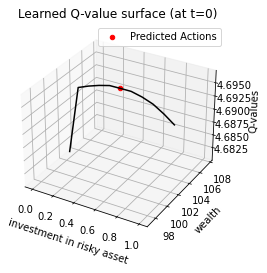

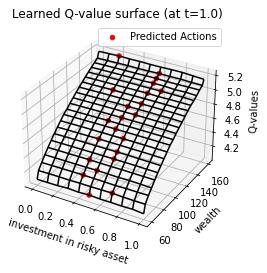

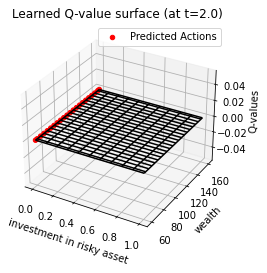

In [13]:
plot_q_values(Q, actions)

In [14]:
def plot_learned_vs_optimal_policy(env, Q, actions):
    '''Plots the learned policy derived from the action-value function Q vs. the optimal policy for logarithmic utility.
    
    Args:
    :params env[gym.environment]: The environment used for collecting samples.
    :params Q[dict]: The Q-Table.
    :params actions[np.array]: np.array containing the possible investment choices.
    '''
    
    # Construct a seperate plot for each time 
    for time in range(1, int(env.num_timesteps)):
        # get the observed wealth levels for each time
        wealth_levels = sorted([wealth for t, wealth in Q.keys() if t == time])
        # Derives the investment choice from the action-value function Q for the given state
        predicted_actions = [decode_action(np.argmax(Q[(time, wealth)]), actions) for wealth in wealth_levels]

        
        # Plots the learned policy
        plt.plot(wealth_levels, predicted_actions, label="learned")
        # Plots the optimal policy for logarithmic utility
        plt.plot(wealth_levels, ((env.mu - env.r)/(env.sigma**2))*np.ones(len(wealth_levels)), "-.", label="optimal")
        plt.title("Learned policy vs. optimal policy (at time t={})".format(time*env.dt))
        plt.xlabel("wealth")
        plt.ylabel("risky asset allocation")
        plt.legend()
        
        plt.show()

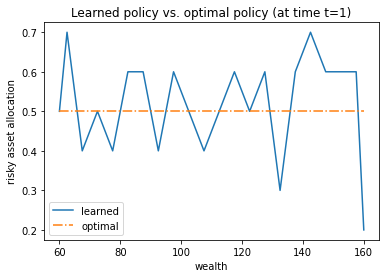

In [15]:
plot_learned_vs_optimal_policy(env, Q, actions)

In [23]:
dill.dump_session('sessions/Discrete_BS_Q_Learning_vectorized_1.db')